Idea parking space:

* Extract features from URL



What I've done so far: 

* Load in the data
* Inspect the data
* Look for unique values with (`df.value_counts`)
* Look for missing values with `df.info`
* Drop na values (todo: refactor this in pipeline)
* Create targets and remove from df

In [115]:
import pandas as pd
import numpy as np
import os

In [116]:
filename = "../../../data/bot-or-not-clickdata.csv"

In [117]:
df = pd.read_csv(filename)

Data: 

* `epoch_ms`
* `session_id`
* `country_by_ip_address`
* `region_by_ip_address`
* `url_without_parameters`
* `referrer_without_parameters`
* `visitor_recognition_type`
* `ua_agent_class`


In [118]:
df.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,NaN,ANONYMOUS,Robot
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,NaN,ANONYMOUS,Robot
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,NaN,ANONYMOUS,Robot
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,NaN,ANONYMOUS,Robot Mobile


In [119]:
mask = df['region_by_ip_address'].isnull()
df = df.loc[~mask]

Let's check for missing data with `df.info()`

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49886 entries, 0 to 59780
Data columns (total 8 columns):
epoch_ms                       49886 non-null int64
session_id                     49886 non-null object
country_by_ip_address          49886 non-null object
region_by_ip_address           49886 non-null object
url_without_parameters         49886 non-null object
referrer_without_parameters    12838 non-null object
visitor_recognition_type       49886 non-null object
ua_agent_class                 49886 non-null object
dtypes: int64(1), object(7)
memory usage: 3.4+ MB


We have some missing values in: 
* `country`
* `region`
* `referrer_without_parameters`

First come up with a very simple model. 

* We drop the column `region_by_ip_address`
* We drop the column `referrer_without_parameters`

In [121]:
df = df.drop(columns=['epoch_ms', 'session_id', 'region_by_ip_address', 'referrer_without_parameters', 'url_without_parameters'])

In [122]:
df.head()

,country_by_ip_address,visitor_recognition_type,ua_agent_class
0,US,ANONYMOUS,Robot
1,US,ANONYMOUS,Robot
2,IT,ANONYMOUS,Browser
3,US,ANONYMOUS,Robot
4,US,ANONYMOUS,Robot Mobile


# Construct target label

Gaan we eerst kijken welke categorieen er in zitten `ua_agent_class`

In [123]:
df['ua_agent_class'].value_counts()

Browser              26667
Robot                15852
Robot Mobile          5115
Browser Webview       1454
Hacker                 690
Special                102
Mobile App               4
Cloud Application        2
Name: ua_agent_class, dtype: int64

In [124]:
def class_to_bot(agent):
    if agent in ["Robot", "Robot Mobile", "Special", "Cloud Application"]: 
        return 1
    else: 
        return 0
    
y = df['ua_agent_class'].apply(class_to_bot)

In [125]:
df = df.drop(columns=['ua_agent_class'])

In [126]:
from sklearn.model_selection import train_test_split

In [135]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.30)

# Construct X variables

In [136]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [144]:
pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')), 
    ('clf', RandomForestClassifier(n_estimators=10))
])

In [145]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(categorical_features=None, categories=None,
                               drop=None, dtype=<class 'numpy.float64'>,
                               handle_unknown='ignore', n_values=None,
                               sparse=True)),
                ('clf',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        o

In [146]:
train_acc = pipe.score(X_train, y_train)
test_acc = pipe.score(X_test, y_test)

In [148]:
print("Accuracy on train set:", train_acc)
print("Accuracy on test set:", test_acc)

Accuracy on train set: 0.959077892325315
Accuracy on test set: 0.9573032206334358


In [151]:
from sklearn.model_selection import GridSearchCV

First we view the parameters with pipeline `params()`

In [153]:
pipe.get_params()

{'memory': None,
 'steps': [('ohe',
   OneHotEncoder(categorical_features=None, categories=None, drop=None,
                 dtype=<class 'numpy.float64'>, handle_unknown='ignore',
                 n_values=None, sparse=True)),
  ('clf',
   RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                          max_depth=None, max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_jobs=None, oob_score=False, random_state=None,
                          verbose=0, warm_start=False))],
 'verbose': False,
 'ohe': OneHotEncoder(categorical_features=None, categories=None, drop=None,
               dtype=<class 'numpy.float64'>, handle_unknown='ignore',
               n_values=None, sparse=True),
 'clf': RandomForestClassifier(bootst

# Gridsearch

We decide to iterate over `min_samples_split`

In [157]:
params = {
    'clf__min_samples_split': [2, 5, 10, 20, 50, 100, 200, 300]
}

In [172]:
# Make sure to enable return train score!!
clf = GridSearchCV(estimator=pipe, param_grid=params, return_train_score=True)

In [173]:
clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('ohe',
                                        OneHotEncoder(categorical_features=None,
                                                      categories=None,
                                                      drop=None,
                                                      dtype=<class 'numpy.float64'>,
                                                      handle_unknown='ignore',
                                                      n_values=None,
                                                      sparse=True)),
                                       ('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                           

In [174]:
clf.cv_results_

{'mean_fit_time': array([0.08140779, 0.0723687 , 0.07732868, 0.07200956, 0.07382631,
        0.07346471, 0.07426643, 0.07048337]),
 'std_fit_time': array([0.00828772, 0.00155878, 0.00283014, 0.00098001, 0.00078882,
        0.003388  , 0.00665328, 0.00153472]),
 'mean_score_time': array([0.02136421, 0.01732802, 0.01892432, 0.01760372, 0.01804161,
        0.01736848, 0.01846957, 0.0179704 ]),
 'std_score_time': array([0.00268588, 0.0005123 , 0.0013419 , 0.00027283, 0.00063057,
        0.00024499, 0.00161849, 0.00074996]),
 'param_clf__min_samples_split': masked_array(data=[2, 5, 10, 20, 50, 100, 200, 300],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__min_samples_split': 2},
  {'clf__min_samples_split': 5},
  {'clf__min_samples_split': 10},
  {'clf__min_samples_split': 20},
  {'clf__min_samples_split': 50},
  {'clf__min_samples_split': 100},
  {'clf__min_samples_split': 200},
  {'clf__mi

In [175]:
results = clf.cv_results_

In [176]:
import matplotlib.pyplot as plt

Sample score mean [0.95906357 0.95906357 0.95904926 0.95906357 0.95906357 0.95907789
 0.95904926 0.95902062]
Sample score std [0.00066638 0.00070058 0.00068579 0.00070058 0.00070058 0.00068129
 0.00068579 0.00067737]
Sample score mean [0.95904926 0.95904926 0.95902062 0.95904926 0.95904926 0.95907789
 0.95902062 0.95902062]
Sample score std [0.00139294 0.00132413 0.00135474 0.00132413 0.00132413 0.00136259
 0.00135474 0.00135474]


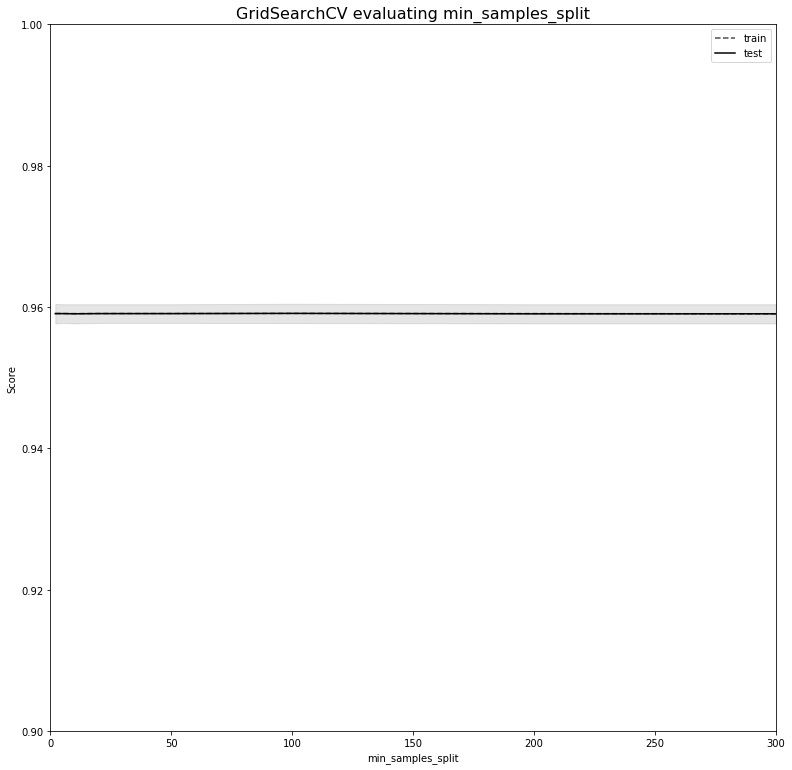

In [184]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating min_samples_split", fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 300)  # set to min value of param grid
ax.set_ylim(0.90, 1)  # accuracy from 0 to 1

# Get the X_values from regular numpy array from the MaskedArray
X_axis = np.array(results["param_clf__min_samples_split"].data, dtype=float)

# For train/test
for sample, style in (("train", "--"), ("test", "-")):
    # Grab results from 
    sample_score_mean = results["mean_%s_score" % (sample)]
    sample_score_std = results["std_%s_score" % (sample)]
    print("Sample score mean", sample_score_mean)
    print("Sample score std", sample_score_std)
    
    # Fill between
    ax.fill_between(
        X_axis,
        sample_score_mean - sample_score_std,
        sample_score_mean + sample_score_std,
        alpha=0.1 if sample == "test" else 0,
        color='k',
    )
    
    ax.plot(
        X_axis,
        sample_score_mean,
        style,
        color='k',
        alpha=1 if sample == "test" else 0.7,
        label="%s" % (sample),
    )

# best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
# best_score = results['mean_test_%s' % scorer][best_index]

# # Plot a dotted vertical line at the best score for that scorer marked by x
# ax.plot([X_axis[best_index], ] * 2, [0, best_score],
#         linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

# # Annotate the best score for that scorer
# ax.annotate("%0.2f" % best_score,
#             (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

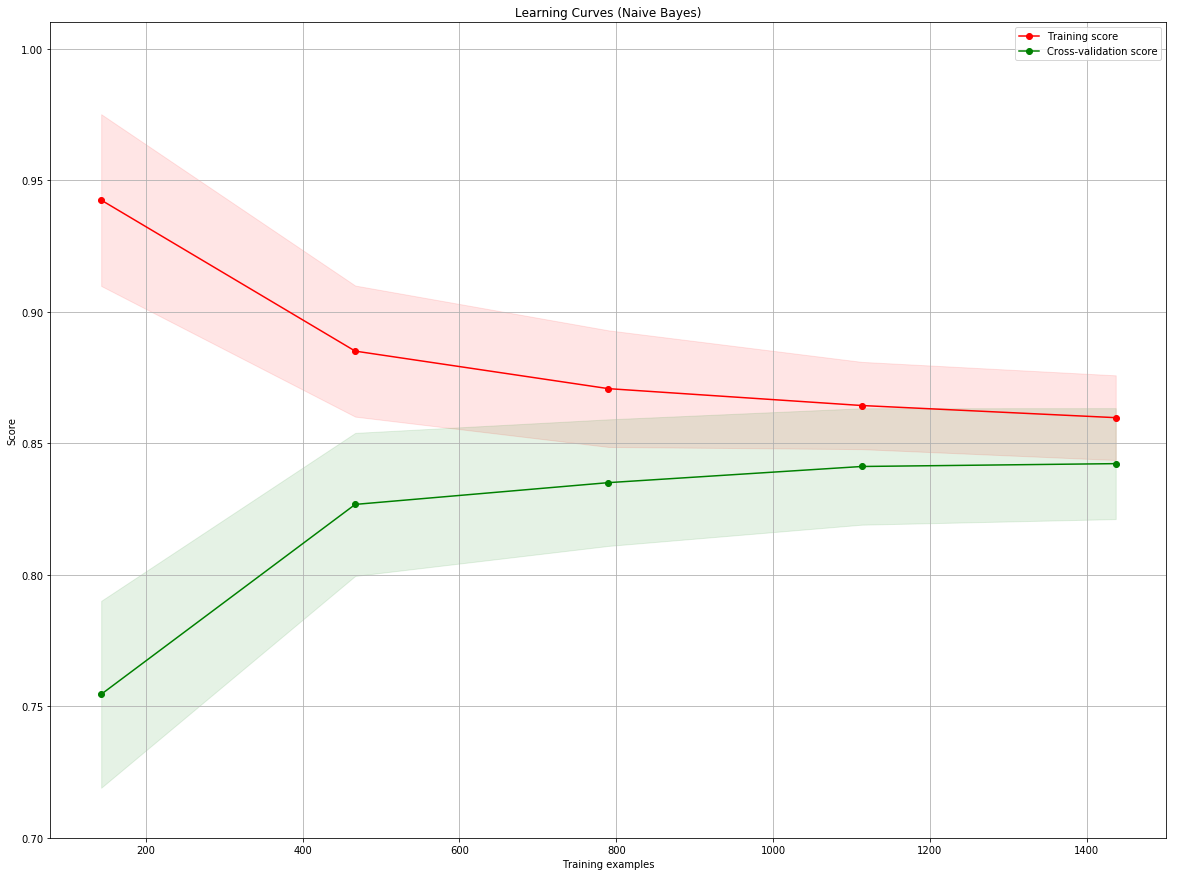

In [198]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 1 plots: the test and training learning curve

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (1,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    # If we don't pass an axes object, make your own
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 15))

    # Set title, ylim, xlabel, and ylabel
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    # Get train_sizes (x-values), train_scores (y-values), and test_scores (y-values)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    # Calculate the mean and std
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot areas
    axes.grid()
    # Plot area for test
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    # Plot area for test
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    # Plot the lines for train
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    # Plot line for test
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")

    return plt


X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

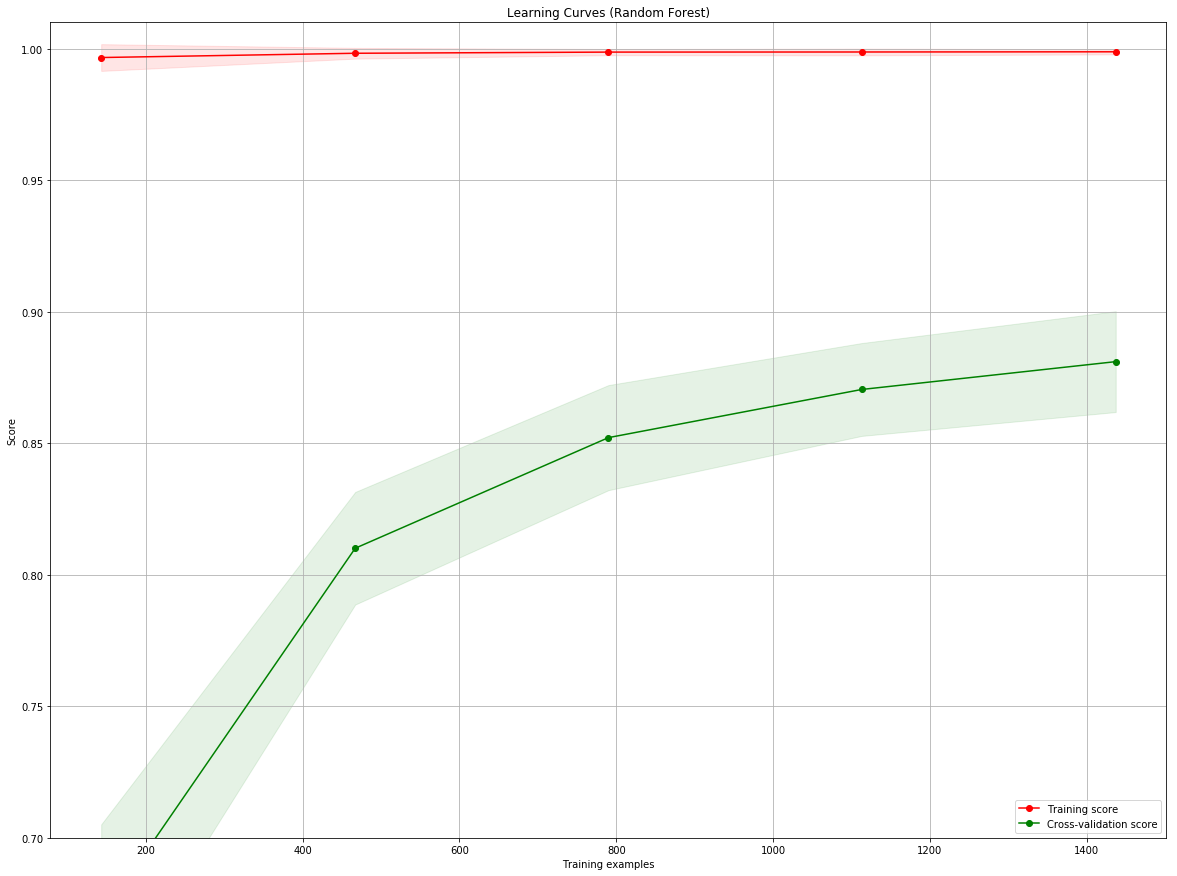

In [200]:
title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(pipe, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [201]:
X.shape

(1797, 64)